### Task 1

In [1]:
import pandas as pd
import json

# File Paths
customer_file = '../data_sources/customer_release.csv'
transaction_file = '../data_sources/transactions_release.parquet'
fraud_file = '../data_sources/fraud_release.json'

# transaction data
transactions = pd.read_parquet(transaction_file)
import json

# Fraud data
with open(fraud_file, 'r') as f:
    fraud_data = json.load(f)
fraud_df = pd.DataFrame(list(fraud_data.items()), columns=['trans_num', 'is_fraud'])

# __merge()
def __merge(customer_filename: str, transaction_filename: str, fraud_filename: str) -> pd.DataFrame:
    customers = pd.read_csv(customer_filename)
    transactions = pd.read_parquet(transaction_filename)
    
    # make 'trans_num' a column
    transactions = transactions.reset_index()
    
    with open(fraud_filename, 'r') as f:
        fraud_dict = json.load(f)
    
    # fraud dictionary to a DataFrame
    fraud = pd.DataFrame(list(fraud_dict.items()), columns=['trans_num', 'is_fraud'])
    
    # Merge customer and transaction using cc_num
    merged_df = pd.merge(transactions, customers, on='cc_num', how='left')
    
    # Merge with the fraud data on trans_num
    merged_df = pd.merge(merged_df, fraud, on='trans_num', how='left')
    
    merged_df = merged_df.sort_values(by='trans_date_trans_time')
    
    return merged_df


merged_data = __merge(customer_file, transaction_file, fraud_file)
print(merged_data.head())


                                trans_num  index_x trans_date_trans_time  \
71408    0b242abb623afc578575680df30655b9        0   2019-01-01 00:00:18   
202364   1f76529f8574734946361c461b024d99        1   2019-01-01 00:00:44   
1040107  a1a22d70485983eac12b5b88dad1cf95        2   2019-01-01 00:00:51   
692044   6b849c168bdad6f867558c3793159a81        3   2019-01-01 00:01:16   
1055958  a41d7549acf90789359a9aa5346dcb46        4   2019-01-01 00:03:06   

                   cc_num     unix_time                            merchant  \
71408    2703186189652095  1.325376e+09                                None   
202364       630423337322  1.325376e+09                                None   
1040107    38859492057661  1.325376e+09                fraud_Lind-Buckridge   
692044   3534093764340240  1.325376e+09  fraud_Kutch, Hermiston and Farrell   
1055958   375534208663984  1.325376e+09                 fraud_Keeling-Crist   

              category     amt  merch_lat  merch_long  ...  \
71408 

### Task 2

#### Insight 1

C:\Users\shrin\AppData\Local\Temp\ipykernel_286648\3975183209.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_by_hour.index, y=fraud_by_hour.values, palette='viridis')


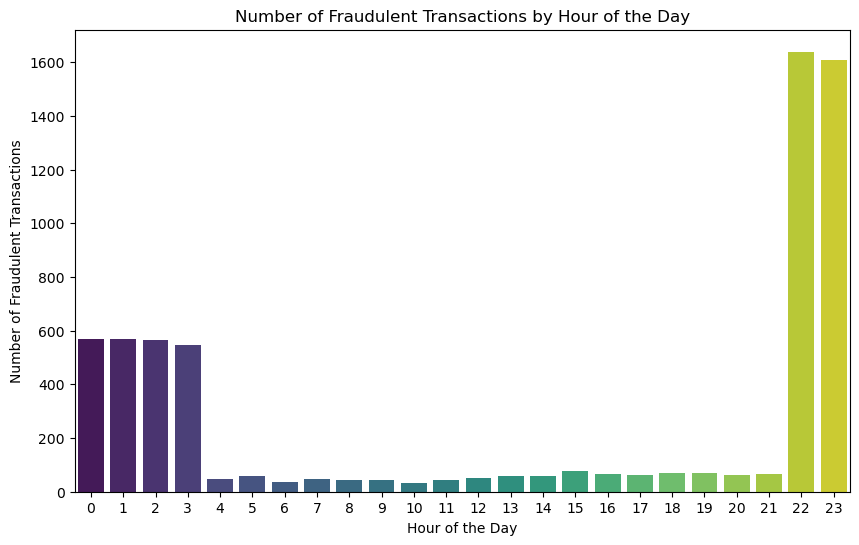

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

#  hour vs  the number of fraudulent transactions

merged_data['hour'] = pd.to_datetime(merged_data['trans_date_trans_time']).dt.hour

fraud_by_hour = merged_data[merged_data['is_fraud'] == 1].groupby('hour').size()

plt.figure(figsize=(10, 6))
sns.barplot(x=fraud_by_hour.index, y=fraud_by_hour.values, palette='viridis')
plt.title('Number of Fraudulent Transactions by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Fraudulent Transactions')
plt.xticks(range(0, 24))
plt.show()


Based on this the first insight is correct. The frequency of transactions is greatest in the early morning/late night hours and during midnight.

#### Insight 2

C:\Users\shrin\AppData\Local\Temp\ipykernel_286648\3130614099.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_by_day.index, y=fraud_by_day.values, palette='viridis')


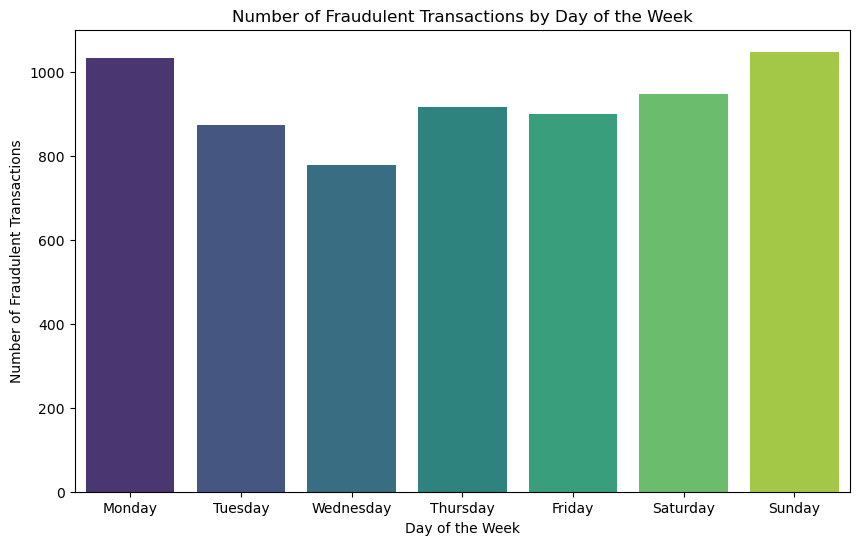

In [3]:
# day of week vs  the number of fraudulent transactions

merged_data['day_of_week'] = pd.to_datetime(merged_data['trans_date_trans_time']).dt.day_name()

fraud_by_day = merged_data[merged_data['is_fraud'] == 1].groupby('day_of_week').size().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.figure(figsize=(10, 6))
sns.barplot(x=fraud_by_day.index, y=fraud_by_day.values, palette='viridis')
plt.title('Number of Fraudulent Transactions by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Fraudulent Transactions')
plt.show()


In [4]:
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(merged_data['day_of_week'], merged_data['is_fraud'])

# chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-Square Test Results")
print("------------------------")
print(f"Chi-square statistic: {chi2:.4f}")
print(f"P-value: {p:.4f}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)


Chi-Square Test Results
------------------------
Chi-square statistic: 186.7511
P-value: 0.0000
Degrees of freedom: 6
Expected frequencies:
[[171210.67931959    753.32068041]
 [294709.28998322   1296.71001678]
 [209685.39200147    922.60799853]
 [273413.98852497   1203.01147503]
 [164925.33460474    725.66539526]
 [215959.78490389    950.21509611]
 [146471.53066212    644.46933788]]


Based on this and the chi square data, it appears that there is an association between the day of the week and the frequency of fradulent claims

#### Insight 3

C:\Users\shrin\AppData\Local\Temp\ipykernel_286648\925454656.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_by_month.index, y=fraud_by_month.values, palette='viridis')


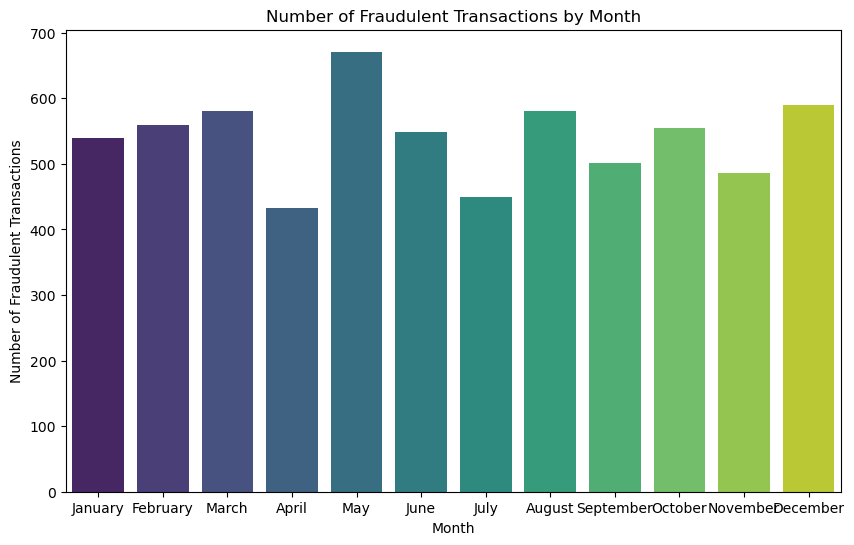

In [5]:
# month vs the number of fraudulent transactions

merged_data['month'] = pd.to_datetime(merged_data['trans_date_trans_time']).dt.month_name()

fraud_by_month = merged_data[merged_data['is_fraud'] == 1].groupby('month').size().reindex(
    ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])

plt.figure(figsize=(10, 6))
sns.barplot(x=fraud_by_month.index, y=fraud_by_month.values, palette='viridis')
plt.title('Number of Fraudulent Transactions by Month')
plt.xlabel('Month')
plt.ylabel('Number of Fraudulent Transactions')
plt.show()


In [6]:
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(merged_data['month'], merged_data['is_fraud'])

# chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-Square Test Results")
print("------------------------")
print(f"Chi-square statistic: {chi2:.4f}")
print(f"P-value: {p:.4f}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)


Chi-Square Test Results
------------------------
Chi-square statistic: 500.2891
P-value: 0.0000
Degrees of freedom: 11
Expected frequencies:
[[107435.28868844    472.71131156]
 [140351.45875301    617.54124699]
 [223616.09741097    983.90258903]
 [ 77899.24618713    342.75381287]
 [ 83697.73305855    368.26694145]
 [137761.85292325    606.14707675]
 [138441.86091315    609.13908685]
 [114456.39607464    503.60392536]
 [116927.52320632    514.47679368]
 [113874.9543966     501.0456034 ]
 [110073.67986448    484.32013552]
 [111839.90852346    492.09147654]]


Based on this and the chi square data, it appears that there is an association between the month and the frequency of fradulent claims.

#### Insight 4

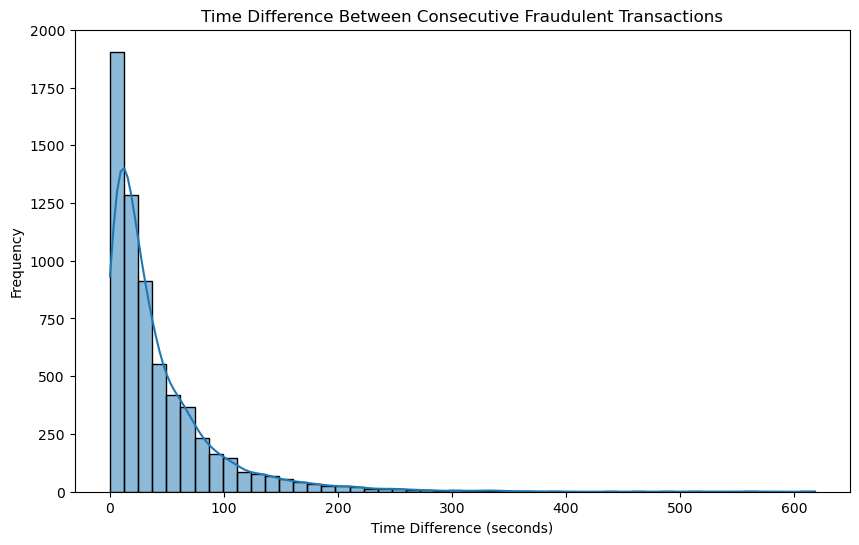

In [7]:
#  fraudulent transactions vs  the time difference distribution

merged_data['time_diff'] = pd.to_datetime(merged_data['trans_date_trans_time']).diff().dt.total_seconds()

fraud_time_diff = merged_data[merged_data['is_fraud'] == 1]['time_diff'].dropna()

plt.figure(figsize=(10, 6))
sns.histplot(fraud_time_diff, bins=50, kde=True)
plt.title('Time Difference Between Consecutive Fraudulent Transactions')
plt.xlabel('Time Difference (seconds)')
plt.ylabel('Frequency')
plt.show()



The analysts are correct, most of the fraudulent transactions are occuring in a very quick sucession.

#### Additional Insight 5

C:\Users\shrin\AppData\Local\Temp\ipykernel_286648\1494475219.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_fraud', y='amt', data=merged_data, palette='viridis')


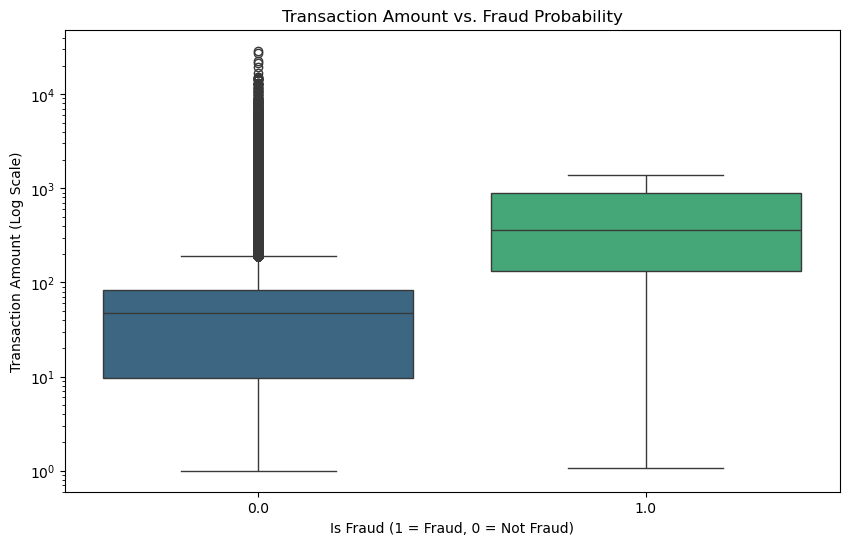

In [8]:
# compare transaction amounts for fraudulent and non-fraudulent transactions
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_fraud', y='amt', data=merged_data, palette='viridis')
plt.yscale('log')  
plt.title('Transaction Amount vs. Fraud Probability')
plt.xlabel('Is Fraud (1 = Fraud, 0 = Not Fraud)')
plt.ylabel('Transaction Amount (Log Scale)')
plt.show()


It appears that the fraud probability is increased with the transaction amount.

#### Additional Insight 6

C:\Users\shrin\AppData\Local\Temp\ipykernel_286648\1065510378.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_by_category.index, y=fraud_by_category.values, palette='viridis')


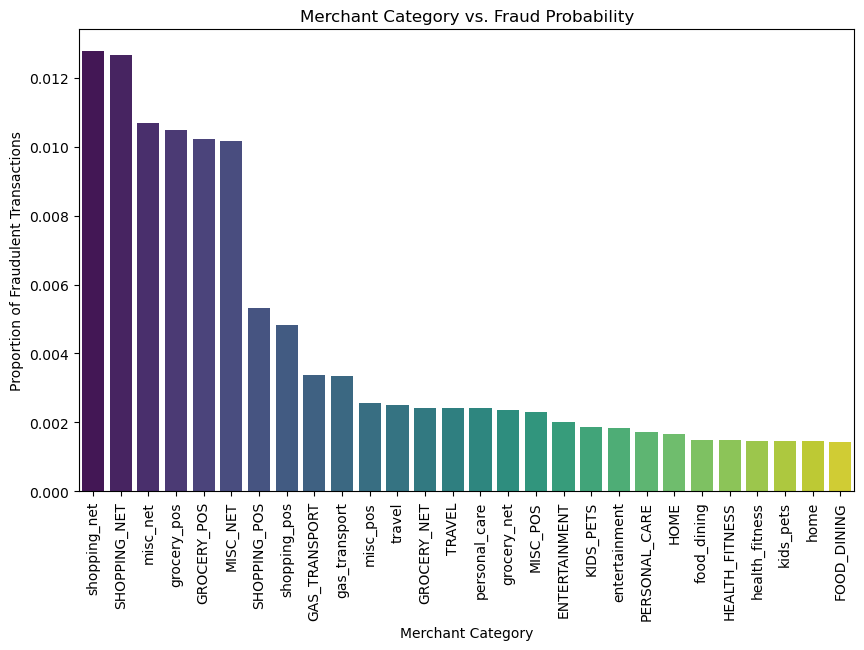

In [9]:
# category vs  the proportion of fraudulent transactions
fraud_by_category = merged_data.groupby('category')['is_fraud'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=fraud_by_category.index, y=fraud_by_category.values, palette='viridis')
plt.title('Merchant Category vs. Fraud Probability')
plt.xlabel('Merchant Category')
plt.ylabel('Proportion of Fraudulent Transactions')
plt.xticks(rotation=90)
plt.show()


It appears that some fields such as net shopping (online) and grocery have a higher risk for fraud over things like fitness or dining.